In [ ]:
!pip install --quiet cornac==1.6.0 adjustText


In [ ]:
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
%matplotlib inline

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import MF, BPR, WMF
from cornac.models import UserKNN, ItemKNN, ConvMF,NeuMF,GMF
from cornac.eval_methods import BaseMethod
%tensorflow_version 1.x
import tensorflow as tf

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE = False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.
System version: 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
Cornac version: 1.6.0
Tensorflow version: 1.15.2


# Import training and probe data

In [ ]:
import pandas as pd
import io
from google.colab import files
uploaded = files.upload()

train_df = pd.read_csv(io.StringIO(uploaded['cs608_ip_train_v2.csv'].decode('utf-8')))
train_df.columns =["UserID", "ItemID", "Rating"]

Saving cs608_ip_train_v2.csv to cs608_ip_train_v2 (1).csv


In [ ]:
uploaded = files.upload()

test_df = pd.read_csv(io.StringIO
(uploaded['cs608_ip_probe_v2.csv'].decode('utf-8')))
test_df.columns =["UserID", "ItemID", "Rating"]

Saving cs608_ip_probe_v2.csv to cs608_ip_probe_v2 (1).csv


# Data Exploration

The basic statistics for ratings

In [ ]:
train_df.Rating.describe()

count    146283.000000
mean          4.066323
std           0.971161
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

Majority of ratings lie in 3 to 5.

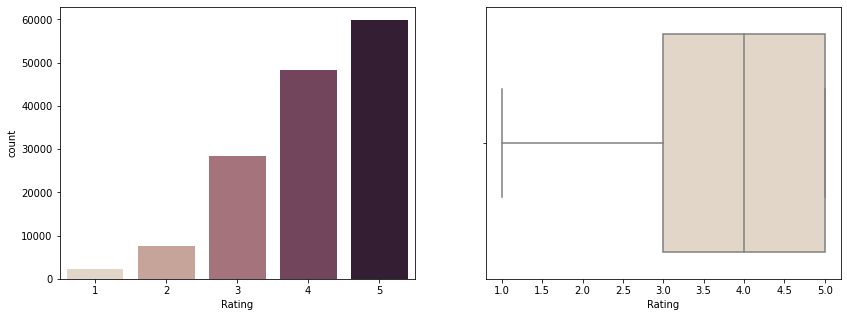

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.countplot(x="Rating", data=train_df, palette="ch:.25", ax=axes[0])
sns.boxplot(x="Rating", data=train_df, palette="ch:.25", ax=axes[1])

In [ ]:
#fil = (train_df['Rating']==1 | train_df['Rating']==2)
newdf = train_df.loc[(train_df.Rating == 1) | (train_df['Rating'] == 2)]
len(newdf)/len(train_df)*100

6.680885680496025

Data Sparsity

In [ ]:
n_users = train_df.UserID.nunique()
n_items = train_df.ItemID.nunique()
n_ratings = len(train_df)
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%")

Number of users: 9402
Number of items: 12411
Number of available ratings: 146283
Number of all possible ratings: 116688222
----------------------------------------
SPARSITY: 99.87%


Power law distribution

Top 10 rated items

In [ ]:
item_rate_count = train_df.groupby("ItemID")["UserID"].nunique().sort_values(ascending=False)
item_rate_count.head(10)

ItemID
7666     1294
3572     1170
5443     1082
9319      888
5277      823
11118     768
10959     675
3367      649
7586      645
8527      630
Name: UserID, dtype: int64

List 10 least rated items. All of them are only rated by 1 user.

In [ ]:
item_rate_count.tail(10)

ItemID
1136     1
9140     1
1142     1
11265    1
7215     1
9149     1
7209     1
9163     1
2903     1
4023     1
Name: UserID, dtype: int64

Recommendations based on item popularity. Performance is quite bad due to power law distribution of user ratings

In [ ]:
train_set = list(train_df.itertuples(index=False,name = None))
test_set = list(test_df.itertuples(index=False, name=None))

In [ ]:

# 5-fold cross validation
rs = RatioSplit(train_set, test_size=0.2, seed=SEED, verbose=VERBOSE)

# recommender system based on item popularity
most_pop = cornac.models.MostPop()

eval_metrics = [
    cornac.metrics.Recall(k=50),
    cornac.metrics.NDCG(k=50),
    cornac.metrics.NCRR(k=50),
]
base_split = BaseMethod.from_splits(
    train_data=train_set,
    test_data=test_set,
    exclude_unknowns=False,
    verbose=True,
)
# put everything together into an experiment
cornac.Experiment(eval_method=base_split, models=[most_pop], metrics=eval_metrics).run()



rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 9402
Number of items = 12411
Number of ratings = 146283
Max rating = 5.0
Min rating = 1.0
Global mean = 4.1
---
Test data:
Number of users = 9402
Number of items = 11160
Number of ratings = 75066
Number of unknown users = 0
Number of unknown items = 255
---
Total users = 9402
Total items = 12666

[MostPop] Training started!

[MostPop] Evaluation started!




TEST:
...
        | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
------- + ------- + ------- + --------- + --------- + --------
MostPop |  0.0793 |  0.1138 |    0.1891 |    0.0035 |  12.0934



User-based models

In [ ]:
K = 50  # number of nearest neighbors
uknn_cosine = UserKNN(
  k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE
)
uknn_cosine_mc = UserKNN(
  k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE
)
uknn_pearson = UserKNN(
  k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE
)
uknn_pearson_mc = UserKNN(
  k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE
)
eval_metrics = [
    cornac.metrics.Recall(k=50),
    cornac.metrics.NDCG(k=50),
    cornac.metrics.NCRR(k=50),
]

base_split = BaseMethod.from_splits(
    train_data=train_set,
    test_data=test_set,
    exclude_unknowns=False,
    verbose=True,
)
cornac.Experiment(
  eval_method=base_split,
  models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
  metrics=eval_metrics,
).run()

rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 9402
Number of items = 12411
Number of ratings = 146283
Max rating = 5.0
Min rating = 1.0
Global mean = 4.1
---
Test data:
Number of users = 9402
Number of items = 11160
Number of ratings = 75066
Number of unknown users = 0
Number of unknown items = 255
---
Total users = 9402
Total items = 12666

[UserKNN-Cosine] Training started!

[UserKNN-Cosine] Evaluation started!




[UserKNN-Cosine-MC] Training started!

[UserKNN-Cosine-MC] Evaluation started!




[UserKNN-Pearson] Training started!

[UserKNN-Pearson] Evaluation started!




[UserKNN-Pearson-MC] Training started!

[UserKNN-Pearson-MC] Evaluation started!




TEST:
...
                   | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
------------------ + ------- + ------- + --------- + --------- + --------
UserKNN-Cosine     |  0.0008 |  0.0018 |    0.0041 |    2.0458 | 492.0495
UserKNN-Cosine-MC  |  0.0006 |  0.0015 |    0.0038 |    1.7970 | 490.4437
UserKNN-Pearson    |  0.0006 |  0.0015 |    0.0038 |    1.8013 | 491.8315
UserKNN-Pearson-MC |  0.0006 |  0.0015 |    0.0038 |    1.8140 | 489.8559



Item-based model

In [ ]:
# ItemKNN methods
K = 50  # number of nearest neighbors
iknn_cosine = ItemKNN(
  k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE
)
iknn_pearson = ItemKNN(
  k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE
)


eval_metrics = [
    cornac.metrics.Recall(k=50),
    cornac.metrics.NDCG(k=50),
    cornac.metrics.NCRR(k=50),
]

base_split = BaseMethod.from_splits(
    train_data=train_set,
    test_data=test_set,
    exclude_unknowns=False,
    verbose=True,
)
cornac.Experiment(
  eval_method=base_split, 
  models=[iknn_cosine, iknn_pearson],
  metrics=eval_metrics,
).run()

rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 9402
Number of items = 12411
Number of ratings = 146283
Max rating = 5.0
Min rating = 1.0
Global mean = 4.1
---
Test data:
Number of users = 9402
Number of items = 11160
Number of ratings = 75066
Number of unknown users = 0
Number of unknown items = 255
---
Total users = 9402
Total items = 12666

[ItemKNN-Cosine] Training started!

[ItemKNN-Cosine] Evaluation started!




[ItemKNN-Pearson] Training started!

[ItemKNN-Pearson] Evaluation started!


matrix factorization

In [ ]:
K = 50
wmf = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")
mf = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, 
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")

eval_metrics = [
    cornac.metrics.Recall(k=50),
    cornac.metrics.NDCG(k=50),
    cornac.metrics.NCRR(k=50),
]

base_split = BaseMethod.from_splits(
    train_data=train_set,
    test_data=test_set,
    exclude_unknowns=False,
    verbose=True,
)
rs = RatioSplit(train_set, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=base_split, models=[wmf, mf], metrics=eval_metrics).run()

rating_threshold = 1.0
exclude_unknowns = False
---
Training data:
Number of users = 9402
Number of items = 12411
Number of ratings = 146283
Max rating = 5.0
Min rating = 1.0
Global mean = 4.1
---
Test data:
Number of users = 9402
Number of items = 11160
Number of ratings = 75066
Number of unknown users = 0
Number of unknown items = 255
---
Total users = 9402
Total items = 12666

[WMF(K=50)] Training started!

[WMF(K=50)] Evaluation started!




[MF(K=50)] Training started!

[MF(K=50)] Evaluation started!




TEST:
...
          | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--------- + ------- + ------- + --------- + --------- + --------
WMF(K=50) |  0.0919 |  0.1552 |    0.2930 |  138.9773 |  21.9437
MF(K=50)  |  0.0023 |  0.0034 |    0.0059 |    0.4947 |  20.6127



Bayesian Personalized Ranking

In [ ]:
K = 50
bpr = BPR(k=K, max_iter=200, learning_rate=0.01, lambda_reg=0.001, 
          verbose=VERBOSE, seed=SEED, name=f"BPR(K={K})")
rs = RatioSplit(train_set, test_size=0.2, seed=SEED, verbose=VERBOSE)
eval_metrics = [
  cornac.metrics.FMeasure(k=50),cornac.metrics.Recall(50)
]
cornac.Experiment(eval_method=rs, models=[bpr], metrics=eval_metrics).run()


TEST:
...
          |  F1@50 | Recall@50 | Train (s) | Test (s)
--------- + ------ + --------- + --------- + --------
BPR(K=50) | 0.0257 |    0.2378 |   16.0166 |  19.2051



First on choice of number of latent factors. The below results show that the optimal K value is between 30 and 50. If K is more than 50, model overfits and test accuracy decreases. 

In [ ]:
K=30 
train_set = list(train_df.itertuples(index=False))
wmf_lr01 = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.01, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")
wmf_lr005 = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.005, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")

wmf_lr0001 = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.0001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")

eval_metrics = [
  cornac.metrics.FMeasure(k=50),cornac.metrics.Recall(50)
]

rs = RatioSplit(train_set, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[wmf_lr01,wmf_lr005,wmf_lr0001], metrics=eval_metrics).run()


TEST:
...
          |  F1@50 | Recall@50 | Train (s) | Test (s)
--------- + ------ + --------- + --------- + --------
WMF(K=30) | 0.0284 |    0.2728 |  290.7241 |  17.2999
WMF(K=30) | 0.0287 |    0.2746 |  294.2089 |  17.5066
WMF(K=30) | 0.0047 |    0.0422 |  299.8173 |  17.6502



Neural Matrix Factorization

In [ ]:

train_set = list(train_df.itertuples(index=False,name = None))
neumf = NeuMF(name='NeuMF', num_factors=30, layers=(128,64,32, 16), act_fn='relu', reg_mf=0.0,reg_layers=(0.0, 0.0, 0.0, 0.0), num_epochs=20,batch_size=256, num_neg=4, lr=0.001,learner='adam', early_stopping=None, trainable=True, verbose=True, seed=None)



eval_metrics = [
  cornac.metrics.FMeasure(k=50),cornac.metrics.Recall(50)
]

rs = RatioSplit(train_set, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[neumf], metrics=eval_metrics).run()



TEST:
...
      |  F1@50 | Recall@50 | Train (s) | Test (s)
----- + ------ + --------- + --------- + --------
NeuMF | 0.0250 |    0.2456 |  359.2256 | 103.6589



In [ ]:
#below 4 as negative rating otherwise pos
train_df_new = train_df
train_df_new['PON'] =  np.where(train_df_new['Rating']<4, 'neg', 'pos')
#train_df_new['User_Pos'] =''
#train_df_new['Item_Pos'] = ''
train_df_new.head()

,UserID,ItemID,Rating,PON
0,2923,7476,4,pos
1,2923,6318,5,pos
2,2923,4595,5,pos
3,2923,7264,5,pos
4,2923,8325,5,pos


In [ ]:
# Transform to a count
#train_df_new.groupby(['UserID','PON'])['PON'].count()
#train_df_new.groupby(['UserID'])['UserID'].count()

User_Res = train_df_new.groupby(['UserID','PON']).agg({'PON': 'count'})
# Change: groupby state_office and divide by sum
User_Per = User_Res.groupby(level=0).apply(lambda x:
                                                  x / float(x.sum()))

In [ ]:
User_Per.columns =['Perc']
#User_Per.reset_index(drop=False)

In [ ]:
User_Per=User_Per.reset_index(drop=False)
User_Per.head()

,UserID,PON,Perc
0,1,neg,0.250000
1,1,pos,0.750000
2,2,neg,0.227273
3,2,pos,0.772727
4,3,neg,0.333333


In [ ]:
# Transform to a count
#train_df_new.groupby(['UserID','PON'])['PON'].count()
#train_df_new.groupby(['UserID'])['UserID'].count()

Item_Res = train_df_new.groupby(['ItemID','PON']).agg({'PON': 'count'})
# Change: groupby state_office and divide by sum
Item_Per = Item_Res.groupby(level=0).apply(lambda x:
                                                  x / float(x.sum()))

In [ ]:
Item_Per.columns =['Perc']
Item_Per=Item_Per.reset_index(drop=False)
Item_Per.head()

,ItemID,PON,Perc
0,1,pos,1.000000
1,2,neg,0.040000
2,2,pos,0.960000
3,3,neg,0.181818
4,3,pos,0.818182


In [ ]:
item_score_lst=[]
for i in range(0,12411):
  data_id = Item_Per['ItemID'] == i
  data_pos = Item_Per['PON'] == 'pos'
  all_filter2 = data_id & data_pos
  if (Item_Per[all_filter2]['Perc'].empty):
    score2=0
  else:
    score2=float(Item_Per[all_filter2]['Perc'])
  item_score_lst.append(score2)


In [ ]:
user_score_lst=[]
for i in range(0,12411):
  data_id = User_Per['UserID'] == i
  data_pos = User_Per['PON'] == 'pos'
  all_filter2 = data_id & data_pos
  if (User_Per[all_filter2]['Perc'].empty):
    score2=0
  else:
    score2=float(User_Per[all_filter2]['Perc'])
  user_score_lst.append(score2)


In [ ]:
#calculate probability 
train_df_new['Score'] = ''
for i in range(0,train_df_new.shape[0]):
  cur_userId = train_df_new['UserID'][i]
  cur_itemId = train_df_new['ItemID'][i]
  data_id = User_Per['UserID'] == cur_userId
  data_pos = User_Per['PON'] == 'pos'
  all_filter1 = data_id & data_pos

  data_id = Item_Per['ItemID'] == cur_itemId
  data_pos = Item_Per['PON'] == 'pos'
  all_filter2 = data_id & data_pos
  if (Item_Per[all_filter2]['Perc'].empty):
    score2=0
  else:
    score2=float(Item_Per[all_filter2]['Perc'])
  if  User_Per[all_filter1]['Perc'].empty:
    score1=0
  else:
    score1=float(User_Per[all_filter1]['Perc'])
  score =score1+score2
  train_df_new['Score'][i]=score

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train_df_new.to_csv('trained_data.csv',index=False)
from google.colab import files
files.download('trained_data.csv')

In [ ]:
train_df_new2 = train_df_new[train_df_new.columns[[0,1,4]]]
train_df_new2.head()
train_df_new2.columns=['UserID','ItemID','Rating']

In [ ]:
K= 30

train_set = list(train_df_new2.itertuples(index=False,name = None))
wmf_30 = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")
mf_30 = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, 
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")
bpr_30 = BPR(k=K, max_iter=200, learning_rate=0.01, lambda_reg=0.001, 
          verbose=VERBOSE, seed=SEED, name=f"BPR(K={K})")
K= 50
wmf_50 = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")
mf_50 = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, 
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")
bpr_50 = BPR(k=K, max_iter=200, learning_rate=0.01, lambda_reg=0.001, 
          verbose=VERBOSE, seed=SEED, name=f"BPR(K={K})")
K= 100
wmf_100 = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")
mf_100 = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.01, 
        verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")
bpr_100 = BPR(k=K, max_iter=200, learning_rate=0.01, lambda_reg=0.001, 
          verbose=VERBOSE, seed=SEED, name=f"BPR(K={K})")

eval_metrics = [
  cornac.metrics.FMeasure(k=50),cornac.metrics.Recall(50)
]

rs = RatioSplit(train_set, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[wmf_30,mf_30,bpr_30,wmf_50,mf_50,bpr_50,wmf_100,mf_100,bpr_100], metrics=eval_metrics).run()


TEST:
...
           |  F1@50 | Recall@50 | Train (s) | Test (s)
---------- + ------ + --------- + --------- + --------
WMF(K=30)  | 0.0302 |    0.3033 |  279.5926 |  18.9573
MF(K=30)   | 0.0007 |    0.0062 |    0.3356 |  15.4382
BPR(K=30)  | 0.0258 |    0.2503 |    8.4723 |  15.1449
WMF(K=50)  | 0.0283 |    0.2870 |  311.9735 |  15.0425
MF(K=50)   | 0.0007 |    0.0061 |    0.4873 |  15.6742
BPR(K=50)  | 0.0256 |    0.2466 |   10.3156 |  15.2996
WMF(K=100) | 0.0264 |    0.2731 |  432.9507 |  15.8171
MF(K=100)  | 0.0007 |    0.0062 |    0.8713 |  14.8946
BPR(K=100) | 0.0253 |    0.2435 |   16.2449 |  14.6808



In [ ]:
train_set = list(train_df_new2.itertuples(index=False,name = None))

K= 15 
wmf_15 = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")

K= 20 
wmf_20 = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")

K= 25
wmf_25 = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")

K= 35
wmf_35 = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")

K= 40
wmf_40 = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")

eval_metrics = [
  cornac.metrics.FMeasure(k=50),cornac.metrics.Recall(50)
]

rs = RatioSplit(train_set, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=[wmf_15,wmf_20,wmf_25,wmf_35,wmf_40], metrics=eval_metrics).run()


TEST:
...
          |  F1@50 | Recall@50 | Train (s) | Test (s)
--------- + ------ + --------- + --------- + --------
WMF(K=15) | 0.0297 |    0.2971 |  230.0189 |  14.4443
WMF(K=20) | 0.0301 |    0.3019 |  246.7829 |  14.3230
WMF(K=25) | 0.0299 |    0.3018 |  262.3031 |  14.7621
WMF(K=35) | 0.0299 |    0.3037 |  287.4748 |  14.8992
WMF(K=40) | 0.0294 |    0.2977 |  283.5247 |  14.6316



In [ ]:
K=35
wmf = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")
train_set = cornac.data.Dataset.from_uir(train_df_new2.itertuples(index=False), seed=SEED)
wmf.fit(train_set)

In [ ]:
user_id2idx = wmf.train_set.uid_map
user_idx2id = list(wmf.train_set.user_ids)
item_id2idx = wmf.train_set.iid_map
item_idx2id = list(wmf.train_set.item_ids)
user_rec_lst = []
user_id_lst=[]
num_of_user = train_df.UserID.nunique()

for i in range(0,num_of_user):
  UIDX = i
  recommendations, scores = wmf.rank(UIDX)
  user_idx = user_idx2id[i]
  
  user_rec_lst.append([int(item_idx2id[j]) for j in recommendations[:50]])
  user_id_lst.append(user_idx)

output_lst = [x for _,x in sorted(zip(user_id_lst,user_rec_lst))]

In [ ]:
#calculate probability 
pred_df_new = pred_df
pred_df_new['Score'] = ''
for i in range(0,pred_df_new.shape[0]):
  cur_userId = pred_df_new['UserID'][i]
  cur_itemId = pred_df_new['ItemID'][i]
  data_id = User_Per['UserID'] == cur_userId
  data_pos = User_Per['PON'] == 'pos'
  all_filter1 = data_id & data_pos

  data_id = Item_Per['ItemID'] == cur_itemId
  data_pos = Item_Per['PON'] == 'pos'
  all_filter2 = data_id & data_pos
  if (Item_Per[all_filter2]['Perc'].empty):
    score2=0
  else:
    score2=float(Item_Per[all_filter2]['Perc'])
  if  User_Per[all_filter1]['Perc'].empty:
    score1=0
  else:
    score1=float(User_Per[all_filter1]['Perc'])
  score =score1+score2
  pred_df_new['Score'][i]=score

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
pred_df_new

,UserID,ItemID,Rating,Score
0,2923,8644,3,1.60784
1,2923,11639,5,1.77273
2,2923,4494,5,1.85714
3,2923,6413,5,1.89474
4,4599,11215,3,1.2381
...,...,...,...,...
75061,4249,301,2,0.538462
75062,4249,9555,5,0.982906
75063,4249,3582,3,0.871795
75064,4249,6676,5,0.982906


In [ ]:
pred_df_new.to_csv('pred_data.csv',index=False)
from google.colab import files
files.download('pred_data.csv')

In [ ]:
train_df_new[train_df_new.columns[[0,4]]]

,UserID,Score
0,2923,1.8
1,2923,1.84096
2,2923,1.90909
3,2923,1.72727
4,2923,2
...,...,...
146278,4249,0.681319
146279,4249,1.13846
146280,4249,1.03846
146281,4249,1.13846


In [ ]:
train_df_new[train_df_new.columns[[0,4]]].groupby('UserID').head(50).reset_index(drop=True)

,UserID,Score
0,2923,1.8
1,2923,1.84096
2,2923,1.90909
3,2923,1.72727
4,2923,2
...,...,...
136083,4249,0.681319
136084,4249,1.13846
136085,4249,1.03846
136086,4249,1.13846


In [ ]:
numofitem = len(set(list(train_df_new['ItemID'])))

In [ ]:
numofitem

12411

In [ ]:
9400*12411

116663400

In [ ]:
K=30
wmf = WMF(k=K, max_iter=100, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, seed=SEED, name=f"WMF(K={K})")
train_set = cornac.data.Dataset.from_uir(train_df.itertuples(index=False), seed=SEED)
wmf.fit(train_set)



In [ ]:
UIDX=1
TOPK=5
item_id2idx = wmf.train_set.iid_map
item_idx2id = list(wmf.train_set.item_ids)

recommendations, scores = wmf.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS:")
print("Scores:", scores[recommendations[:TOPK]])
recommendations



TOP 5 RECOMMENDATIONS:
Scores: [2.7322319 2.6792727 2.6511228 2.5879054 2.5758662]


array([   8,   83, 1158, ..., 2518, 1748, 1191])

In [ ]:
user_id2idx = wmf.train_set.uid_map
user_idx2id = list(wmf.train_set.user_ids)


In [ ]:
len(user_id2idx)

9402

In [ ]:
user_rec_lst = []
user_id_lst=[]

In [ ]:
num_of_user = train_df.UserID.nunique()
num_of_user

9402

In [ ]:
for i in range(0,num_of_user):
  UIDX = i
  recommendations, scores = wmf.rank(UIDX)
  user_idx = user_idx2id[i]
  
  user_rec_lst.append([int(item_idx2id[j]) for j in recommendations[:50]])
  user_id_lst.append(user_idx)


In [ ]:
output_lst = [x for _,x in sorted(zip(user_id_lst,user_rec_lst))]

Implicit Method with ALS

In [ ]:
!pip install implicit

     |████████████████████████████████| 1.1MB 3.2MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3420306 sha256=c596af41278062ab0e7cfdb0b0b9427ccc654e8283f69bf847425ce4c56287c2
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [ ]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import random
import implicit
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [ ]:

train_df['UserID']= train_df['UserID'].astype("category")
train_df['ItemID'] = train_df['ItemID'].astype("category")
train_df['User_ID']= train_df['UserID'].cat.codes
train_df['Item_ID'] = train_df['ItemID'].cat.codes

In [ ]:
d = dict(enumerate(train_df['UserID'].cat.categories))
print (d)

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17, 17: 18, 18: 19, 19: 20, 20: 21, 21: 22, 22: 23, 23: 24, 24: 25, 25: 26, 26: 27, 27: 28, 28: 29, 29: 30, 30: 31, 31: 32, 32: 33, 33: 34, 34: 35, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50, 50: 51, 51: 52, 52: 53, 53: 54, 54: 55, 55: 56, 56: 57, 57: 58, 58: 59, 59: 60, 60: 61, 61: 62, 62: 63, 63: 64, 64: 65, 65: 66, 66: 67, 67: 68, 68: 69, 69: 70, 70: 71, 71: 72, 72: 73, 73: 74, 74: 75, 75: 76, 76: 77, 77: 78, 78: 79, 79: 80, 80: 81, 81: 82, 82: 83, 83: 84, 84: 85, 85: 86, 86: 87, 87: 88, 88: 89, 89: 90, 90: 91, 91: 92, 92: 93, 93: 94, 94: 95, 95: 96, 96: 97, 97: 98, 98: 99, 99: 100, 100: 101, 101: 102, 102: 103, 103: 104, 104: 105, 105: 106, 106: 107, 107: 108, 108: 109, 109: 110, 110: 111, 111: 112, 112: 113, 113: 114, 114: 115, 115: 116, 116: 117, 117: 118, 118: 119, 119: 120, 120: 121, 121: 12

In [ ]:
d[2922]

2923

In [ ]:
train_df.head()

,UserID,ItemID,Rating,User_ID,Item_ID
0,2923,7476,4,2922,7306
1,2923,6318,5,2922,6165
2,2923,4595,5,2922,4486
3,2923,7264,5,2922,7095
4,2923,8325,5,2922,8133


In [ ]:

sparse_content_person = sparse.csr_matrix((train_df['Rating'].astype(float), (train_df['Item_ID'], train_df['User_ID'])))
sparse_person_content = sparse.csr_matrix((train_df['Rating'].astype(float), (train_df['User_ID'], train_df['Item_ID'])))

In [ ]:
model = implicit.als.AlternatingLeastSquares(factors=32, regularization=0.1, iterations=50)
alpha = 15
data = (sparse_content_person * alpha).astype('double')

# Fit the model
model.fit(data)

In [ ]:
content_id = 450
n_similar = 10

person_vecs = model.user_factors
content_vecs = model.item_factors

content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1))

scores = content_vecs.dot(content_vecs[content_id]) / content_norms
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
similar = sorted(zip(top_idx, scores[top_idx] / content_norms[content_id]), key=lambda x: -x[1])

In [ ]:
for content in similar:
    idx, score = content
    print(train_df.Item_ID.loc[train_df.Item_ID == idx].iloc[0])

450
2561
11
10215
7981
4904
8849
3328
12054
8064


In [ ]:
def recommend(person_id, sparse_person_content, person_vecs, content_vecs, num_contents=50):
    person_interactions = sparse_person_content[person_id,:].toarray()
    person_interactions = person_interactions.reshape(-1) + 1
    person_interactions[person_interactions > 1] = 0
    rec_vector = person_vecs[person_id,:].dot(content_vecs.T).toarray()
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]

    recommend_vector = person_interactions * rec_vector_scaled
    content_idx = np.argsort(recommend_vector)[::-1][:num_contents]
    
    items = []
    scores = []

    for idx in content_idx:
        items.append(train_df.ItemID.loc[train_df.Item_ID == idx].iloc[0])
        scores.append(recommend_vector[idx])

    recommendations = pd.DataFrame({'item': items, 'score': scores})

    return recommendations

Make recommendations to users

In [ ]:
num_of_user = train_df.UserID.nunique()
num_of_user

9402

In [ ]:
person_vecs = sparse.csr_matrix(model.user_factors)
content_vecs = sparse.csr_matrix(model.item_factors)
user_rec_lst = []
user_id_lst=[]
for i in range(0,num_of_user):
  person_id = i
  recommendations = recommend(person_id, sparse_person_content, person_vecs, content_vecs)
  user_rec_lst.append(list(recommendations.item))
  user_id_lst.append(d[i])

In [ ]:
recommendations = recommend(person_id, sparse_person_content, person_vecs, content_vecs)

In [ ]:
output_lst = [x for _,x in sorted(zip(user_id_lst,user_rec_lst))]

Evaluation

Recall-50

In [ ]:
#test_df['ItemID'] = test_df['ItemID'].astype(np.uint8)
recall_lst = []
for i in range(0,num_of_user):
  true_userid = d[i]
  recommened_itemlst = output_lst[d[i]-1]
  user_cur = test_df.loc[test_df['UserID']==true_userid]
  user_cur = user_cur.sort_values(by=['Rating'],ascending=False)
  if user_cur.shape[0]<=50:
    ground_truth = set(user_cur['ItemID'])
    
  else: 
    ground_truth = set(user_cur['ItemID'][:50])
  recall = len(set(recommened_itemlst) & set(ground_truth))/len(ground_truth)
  recall_lst.append(recall)

In [ ]:
recall_50 = sum(recall_lst) / len(recall_lst) 
print(recall_50)

0.3388373152365161


Parameter Tuning

In [ ]:
alpha_lst = [5,15,25]

for i in range(0,len(alpha_lst)):
  model = implicit.als.AlternatingLeastSquares(factors=32, regularization=0.1, iterations=50)
  alpha = alpha_lst[i]
  data = (sparse_content_person * alpha).astype('double')

  # Fit the model
  model.fit(data)
  person_vecs = sparse.csr_matrix(model.user_factors)
  content_vecs = sparse.csr_matrix(model.item_factors)
  user_rec_lst = []
  user_id_lst=[]
  for i in range(0,num_of_user):
    person_id = i
    recommendations = recommend(person_id, sparse_person_content, person_vecs, content_vecs)
    user_rec_lst.append(list(recommendations.item))
    user_id_lst.append(d[i])
  output_lst = [x for _,x in sorted(zip(user_id_lst,user_rec_lst))]
  recall_lst = []
  for i in range(0,num_of_user):
    true_userid = d[i]
    recommened_itemlst = output_lst[d[i]-1]
    user_cur = test_df.loc[test_df['UserID']==true_userid]
    user_cur = user_cur.sort_values(by=['Rating'],ascending=False)
    if user_cur.shape[0]<=50:
      ground_truth = set(user_cur['ItemID'])
      
    else: 
      ground_truth = set(user_cur['ItemID'][:50])
    recall = len(set(recommened_itemlst) & set(ground_truth))/len(ground_truth)
    recall_lst.append(recall)
  recall_50 = sum(recall_lst) / len(recall_lst) 
  print('Recall for alpha '+str(alpha)+' is '+str(recall_50))


Recall for alpha 5 is 0.336090223047496



Recall for alpha 15 is 0.3404429001099177



Recall for alpha 25 is 0.3368934673810467
